In [1]:
import os
import numpy as np
import datetime as DT

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Set pandas printout options, for better look
pd.set_option('display.max_row', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('expand_frame_repr', False)
pd.set_option('max_colwidth', 60)

## Set train data root path
root_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))

df = pd.read_csv(root_path+'/dataset/userprofiling/'+'query_result_reg_all_20june17.csv',dtype={'article_id':'str','user_id':'str','city':'str'})

## Change birthdate format, so we can calculate age of every related id
df['birthdate'] = df['birthdate'].apply('{:06}'.format)
df['birthdate'] = pd.to_datetime(df['birthdate'], format='%m%d%y')

rep_var=['','N-A'] #variable replace

## Clear all NaN Value, so become more readable
df = df.replace(np.nan, rep_var[1], regex=True)

## Create new copy of prior DataFrame and
##  Select only appropriate column
##    and filter empty `topic_id`
df_filter = df.loc[(df['topic_id'] != '') & (df['city'] != '') & (df['os'] != ''), \
    ['user_id','gender','birthdate','event','event_time','city','browser','os','device'\
    ,'carrier','manufacturer','duration','topic_id','article_id']]

now = pd.Timestamp(DT.datetime.now())

## Calculate Age, by subtracting variable now(which is current date) and birtdate
df_filter['birthdate'] = df_filter['birthdate'].where(df_filter['birthdate'] < now, df_filter['birthdate'] -  np.timedelta64(100, 'Y'))
df_filter['birthdate'] = (now - df_filter['birthdate']).astype('<m8[Y]')

df_filter.head(5) # get top 5

/root/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_id,gender,birthdate,event,event_time,city,browser,os,device,carrier,manufacturer,duration,topic_id,article_id
0,1026349329,male,21.0,read_article,2017-03-07 06:56:59,Jakarta,N-A,Android,N-A,TELKOMSEL,OnePlus,N-A,"22553543,522681656,41566010,46170458,1027266267",1028322564
1,1035461267,male,28.0,read_article,2017-04-26 21:14:18,Surabaya,Chrome,Android,Android,N-A,N-A,N-A,"143865906,27432949,98040676,52353894,1035581805",1036034482
2,701987221,male,62.0,article_comment,2017-05-23 18:07:11,Jakarta,N-A,Android,N-A,TELKOMSEL,LENOVO,N-A,N-A,N-A
3,771752788,male,25.0,spent_time,2017-02-23 07:43:15,Jakarta,N-A,Android,N-A,TELKOMSEL,samsung,N-A,"361858614,46904429,91265302,27428266",1009162668
4,765731006,female,21.0,spent_time,2017-03-10 19:45:39,Jakarta,N-A,Android,N-A,TELKOMSEL,OPPO,N-A,N-A,1032594876


* * *

## All unique user_id x Carrier

In [4]:
df_filter['carrier'] = df_filter['carrier'].str.lower()

df_carrier_unique = df_filter[['user_id','carrier']].loc[(df_filter['carrier']!='n-a')].groupby(['user_id','carrier']).size().to_frame()
df_carrier_unique.index.names=['user_id','carrier']
df_carrier_unique.reset_index(inplace=True)
df_carrier_unique = df_carrier_unique.rename(columns={0: 'count'})

print df_carrier_unique['carrier'].describe(),"\n"
print df_carrier_unique.groupby('carrier').size()

count          3853
unique          117
top       telkomsel
freq           1629
Name: carrier, dtype: object 

carrier
,3                    1
3                   287
3,indosat             1
510 09               18
510 28               14
51009                 2
51028                 1
                   ... 
xl axiata           144
xl star               1
xl,3                  1
xl,ind telkomsel      2
xl,xl                 1
yes optus             1
zain jo               1
Length: 117, dtype: int64


In [7]:
# Variable sanity check
len(df_carrier_unique.loc[df_carrier_unique['carrier']=='telkomsel'])

         user_id          carrier  count
0     1000548159          carrier    210
1     1000570617        telkomsel      6
2     1000607531  indosat ooredoo    608
3     1000934985        telkomsel     66
4     1001341258        telkomsel     76
5     1001934100             axis     13
6     1001934100      ind indosat     11
...          ...              ...    ...
3846   998189335        telkomsel    335
3847   998292573  indosat ooredoo     33
3848   998581740        telkomsel      2
3849   998773504        smartfren    133
3850   999384077          carrier     65
3851   999424993        xl axiata     37
3852   999608583               xl      2

[3853 rows x 3 columns]


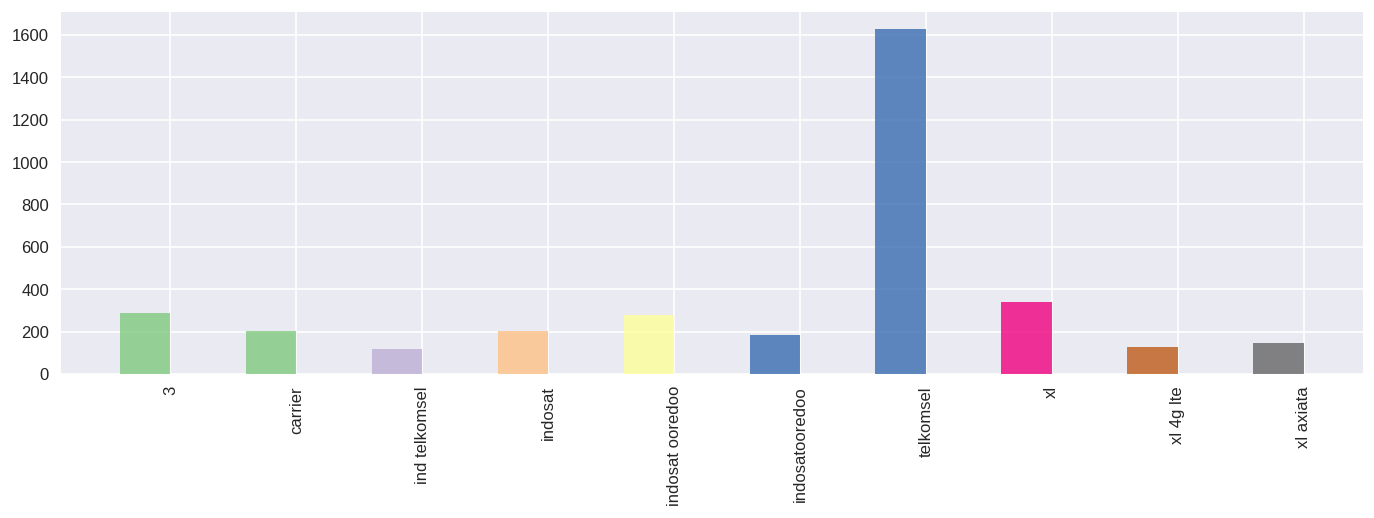

In [8]:
from matplotlib import cm
from itertools import cycle, islice

df_carrier = df_carrier_unique[['carrier']].groupby('carrier').size().to_frame()

df_carrier.index.names = ['carrier']
df_carrier.reset_index(inplace=True)
df_carrier = df_carrier.rename(columns= {0: 'count'})

opacity = 0.8
df_carrier_fil = df_carrier.loc[(df_carrier['count'] > 100)]

figcarrier = plt.figure(figsize=(14,4), dpi=120)
axcarrier  = figcarrier.add_subplot(111)

n = len(df_carrier_fil['count'])
pos = list(range(n))
width = 0.4

# Set the position of the x ticks
axcarrier.set_xticks([p + 2 * width for p in pos])
# Set the labels for the x ticks
axcarrier.set_xticklabels(df_carrier_fil['carrier'])
# Rotate X-Ticks
plt.xticks(rotation=90)

# Define Colors
color_list = []
for i in range(0, n):
    color_list.append(cm.Accent(1.*i/n))
    
my_colors = list(islice(cycle(color_list), None, len(df_carrier_fil)))

# plot the bars
plt.bar([p + width*1.5 for p in pos], df_carrier_fil['count'], width, \
        alpha=opacity, color=my_colors)

plt.show()

In [31]:
# Grouping similar carrier name, becacuse inconsistency naming carrier
carrier_to_select = ['xl','telkomsel','indosat']
carrier_similarname = {}

for car in carrier_to_select:
    carrier_similarname[car]=df_carrier_fil['count'].loc[(df_carrier_fil['carrier'].str.contains(car, case=False))].sum()

df_carrier_similarname = pd.DataFrame(carrier_similarname.items(), columns=['Carrier', 'Count'])

df_carrier_similarname

,Carrier,Count
0,telkomsel,1749
1,indosat,663
2,xl,611


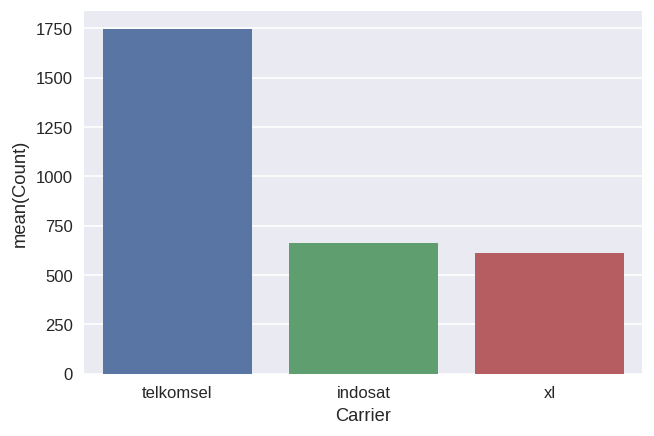

In [40]:
figsimcar, axsimcar = plt.subplots(figsize=(6,4), dpi=120)
sns.barplot(x='Carrier', y='Count', data=df_carrier_similarname, ax=axsimcar)
plt.show()

## All unique user_id x Age

In [44]:
print "Total Unique User: %d"%len(df_filter[['user_id']].groupby('user_id').size())

Total Unique User: 11711


In [45]:
## Rename field for better understanding with Database
df_filter.rename(columns={'birthdate': 'age','article_id':'story_id'}, inplace=True)

In [46]:
df_age_unique = df_filter[['user_id','age']].groupby(['user_id','age']).size().to_frame()
df_age_unique.index.names=['user_id','age']
df_age_unique.reset_index(inplace=True)
df_age_unique = df_age_unique.rename(columns={0: 'count'})

print df_age_unique['age'].describe(),"\n"
print df_age_unique.groupby('age').size()

count    11711.000000
mean        33.250021
std         13.664005
min          0.000000
25%         22.000000
50%         29.000000
75%         41.000000
max         99.000000
Name: age, dtype: float64 

age
0.0      3
1.0      8
2.0      2
3.0      2
4.0      2
5.0      1
6.0      9
        ..
93.0     2
94.0     1
95.0     1
96.0     3
97.0    12
98.0     9
99.0     2
Length: 97, dtype: int64


In [47]:
print "Central Tendency Measurements:"
print "-"*30
print "Mean   : %f"% df_age_unique['age'].mean()
print "Median : %f"% df_age_unique['age'].median()
print "Mode   : %f"% df_age_unique['age'].mode().iloc[0]

Central Tendency Measurements:
------------------------------
Mean   : 33.250021
Median : 29.000000
Mode   : 21.000000


In [48]:
print "Measure of Dispersion:"
print "-"*30
print "Standard Deviation: %f"%df_age_unique['age'].std()
print "Variance          : %f"%df_age_unique['age'].var() # this just math.sqrt(df_filter['age'].std())
print "Range             : %f"%(df_age_unique['age'].max() - df_age_unique['age'].min())

Measure of Dispersion:
------------------------------
Standard Deviation: 13.664005
Variance          : 186.705033
Range             : 99.000000


In [52]:
import math
print "Standard Error of The Mean: %f"%(df_age_unique['age'].std()/math.sqrt(df_age_unique['age'].count()))
print "-"*25
print "The SE of "+str(df_age_unique['age'].std()/math.sqrt(df_age_unique['age'].count()))+", being relatively small, gives us an indication that our mean is relatively close to the true mean of our overall population."

Standard Error of The Mean: 0.126264
-------------------------
The SE of 0.126264429935, being relatively small, gives us an indication that our mean is relatively close to the true mean of our overall population.


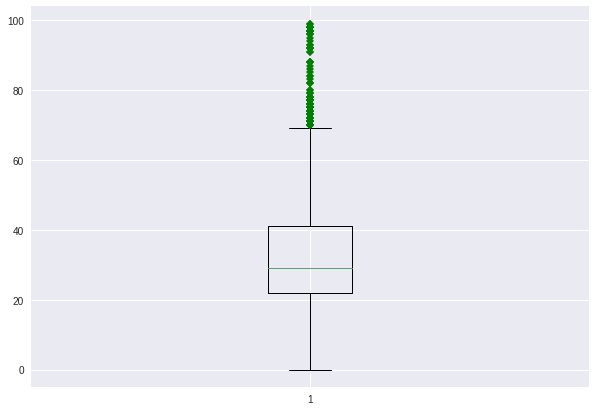

In [55]:
plt.figure(figsize=(10,7))
plt.boxplot(df_age_unique['age'], 0, 'gD')
plt.show()

Those **green points** on boxplot represent **potential outliers**.

In [56]:
print "Shape of Distribution:"
print "-"*30
print "Skewness : %f"%df_age_unique['age'].skew()
print "Kurtosis : %f"%df_age_unique['age'].kurt()

Shape of Distribution:
------------------------------
Skewness : 1.149541
Kurtosis : 1.461665


If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left.

If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.

If skewness = 0, the data are perfectly symmetrical. But a skewness of exactly zero is quite unlikely for real-world data, so how can you interpret the skewness number? Bulmer (1979) — a classic — suggests this rule of thumb:

* If skewness is less than −1 or greater than +1, the distribution is highly skewed.
* If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
* If skewness is between −½ and +½, the distribution is approximately symmetric.

The reference standard is a normal distribution, which has a kurtosis of 3.

In token of this, often the excess kurtosis is presented: excess kurtosis is simply kurtosis−3. For example, the “kurtosis” reported by Excel is actually the excess kurtosis.

* A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called **mesokurtic**.
* A distribution with kurtosis <3 (excess kurtosis <0) is called **platykurtic**. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.
* A distribution with kurtosis >3 (excess kurtosis >0) is called **leptokurti**c. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.

Kita coba dengan mengelompokkan data kedalam 5 bagian umur:

Group      | Age
-----------| ---
Tenage     | < 18
Youngster  | 18-24
Young      | 25-34
Mid-Age    | 35-49
Elder      | > 49

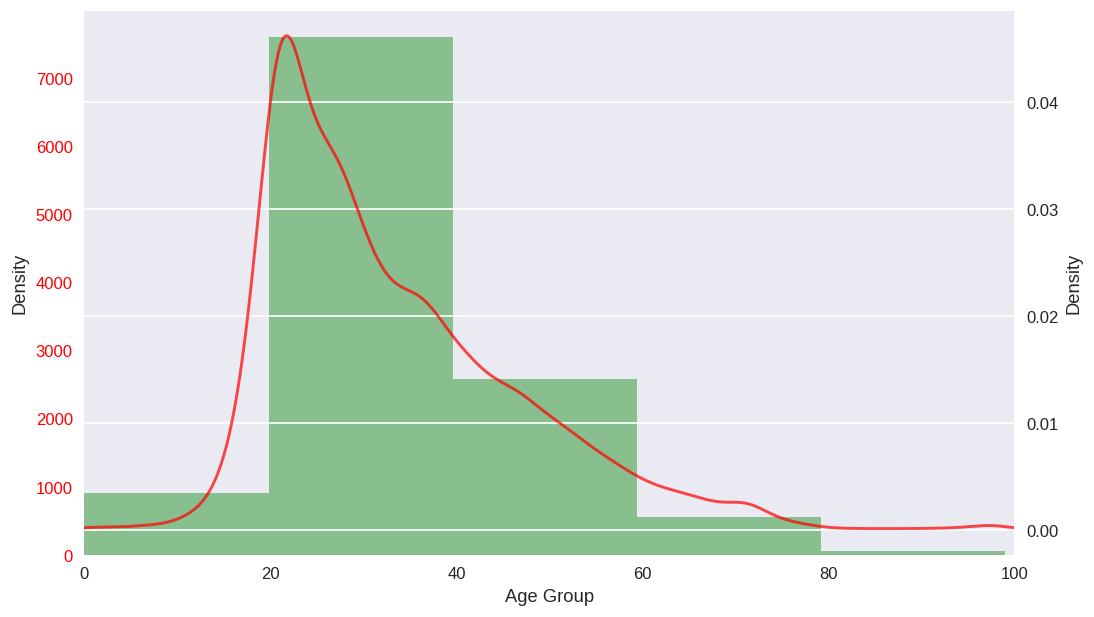

In [59]:
figagesh, axagesh = plt.subplots(figsize=(10,6), dpi=120)

axagesh.set_ylabel("Freq")
axagesh.tick_params('y', colors='r')
axagesh.set_xlabel('Age Group')

df_age_unique.age.plot(kind='hist', ax=axagesh, xlim=[0, 100], bins=5, color='g', alpha=.41)
df_age_unique.age.plot(kind='kde', ax=axagesh, secondary_y=True, color='r',xlim=[0, 100], alpha=.71)

plt.ylabel('Density')
plt.show()